# Predict IMDB movie rating
## part 02 Data Preprocessing
This section is used to preprocess dataset. It consists of 4 steps

1. Duplicate
2. Missing Value
3. Outliers
4. Featrue Engineering

# Setup

In [3]:
# load libraries
import pandas as pd
import seaborn as sns
import imdb
import re
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from sklearn.ensemble import RandomForestRegressor
import category_encoders as ce
import math

In [4]:
# read dataset
df_path = 'https://raw.githubusercontent.com/sundeepblue/movie_rating_prediction/master/movie_metadata.csv'
df = pd.read_csv(df_path, dtype = {'aspect_ratio': str})
imdb_df_path = 'https://raw.githubusercontent.com/Carloszone/IMDB_Rating_prediction/main/IMDA_DATA.csv'
imdb_df = pd.read_csv(imdb_df_path,dtype = {'No':str})

### Duplicate
Remove all duplicate from dataset by imdb link

In [5]:
df_d = df.drop_duplicates(subset=['movie_imdb_link']).reset_index(drop = True)
imdb_df_d = imdb_df.drop_duplicates(subset=['No']).reset_index(drop = True)

### Missing values
1. firgue out the missing values in the data set
2. implement filling strategy to fill missing values

#### filling strategies
1. Extract movie data via cinemagoer package and fill missing value
2. If missing values still exist: 
- for numeric variables, fill missing values with mean
- for categorical variables, fill missing values with 'Other'

In [6]:
# parameters
def get_cvariables_type(df):
    if 'imdb_score' in df.columns.tolist():
        df = df.drop('imdb_score', axis = 1)
    cate_var = df.dtypes[df.dtypes == 'object'].index.tolist()
    num_var = df.dtypes[df.dtypes != 'object'].index.tolist()
    return cate_var, num_var

# funciton to report missing values(percentage)
def na_checker(df, directly_print = 1, remove_no_na = 1):
    na_fre =  df.isna().sum().sort_values(ascending=False)
    na_per = df.isna().sum().sort_values(ascending=False)/len(df) * 100
    ind = na_per.index.tolist()
    res = pd.DataFrame({'Column_Name': ind, 'Frequency':na_fre, 'Percentage':na_per})
    res = res.set_index('Column_Name')
    if remove_no_na == 1:
        res = res[res.Percentage != 0]
        res.to_csv('missing_value.csv')
    if directly_print == 1:
        print(res)
    return ind

# function to fill missing values
def fill_na(df1, df2, cols):
    df = df1.copy()
    cate_vars, num_vars = get_cvariables_type(df)
    # fill missing value with imdb_data
    for col in cols:
        if col in ['director_facebook_likes', 'actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes']:
            df[col] = df[col].combine_first(df['director_facebook_likes']).combine_first(df['actor_1_facebook_likes']).combine_first(df['actor_2_facebook_likes']).combine_first(df['actor_3_facebook_likes'])
        elif col == 'gross':
            pass
        elif col in df2.columns:
            df[col] = df[col].combine_first(df2[col])
        
        # fill missing value with "other" or mean
        if col in cate_vars:
            df[col] = df[col].fillna('Other')
        else:
            avg = int(df[col].mean())
            df[col] = df[col].fillna(avg)
    return df

In [7]:
columns_na = na_checker(df_d)
df_d_m = fill_na(df_d,imdb_df_d, columns_na)

                         Frequency  Percentage
Column_Name                                   
gross                          863   17.544216
budget                         485    9.859728
aspect_ratio                   326    6.627363
content_rating                 301    6.119130
plot_keywords                  152    3.090059
title_year                     106    2.154910
director_name                  102    2.073592
director_facebook_likes        102    2.073592
num_critic_for_reviews          49    0.996137
actor_3_name                    23    0.467575
actor_3_facebook_likes          23    0.467575
num_user_for_reviews            21    0.426916
color                           19    0.386257
duration                        15    0.304940
facenumber_in_poster            13    0.264281
actor_2_name                    13    0.264281
actor_2_facebook_likes          13    0.264281
language                        12    0.243952
actor_1_name                     7    0.142305
actor_1_faceb

### Outliers
According to previous EDA, locate all outliers.Then, remove ooutliers and check plot
1. If they are a mild outlier, keet it
2. If they are not mild, remove it

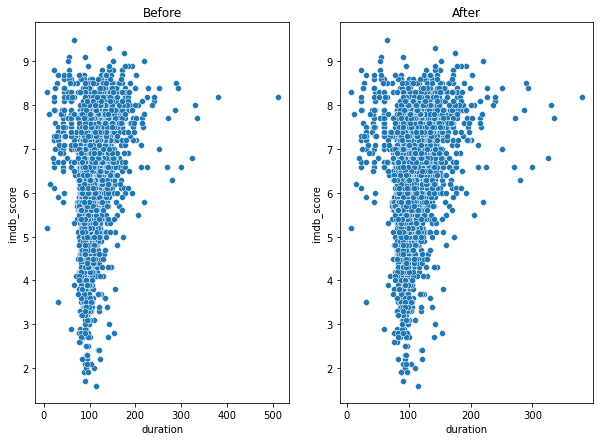

In [6]:
# duration
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,7))
sns.scatterplot(x='duration', y="imdb_score", data=df_d_m, ax = ax1)
sns.scatterplot(x='duration', y="imdb_score", data=df_d_m[df_d_m['duration']<400], ax = ax2)
ax1.title.set_text('Before')
ax2.title.set_text('After')
plt.show()

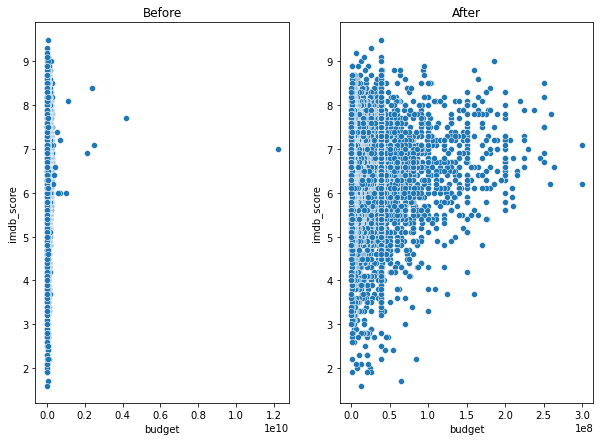

In [7]:
#budget
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,7))
sns.scatterplot(x='budget', y="imdb_score", data=df_d_m, ax = ax1)
sns.scatterplot(x='budget', y="imdb_score", data=df_d_m[df_d_m['budget']< 3.5* 10**8], ax = ax2)
ax1.title.set_text('Before')
ax2.title.set_text('After')
plt.show()

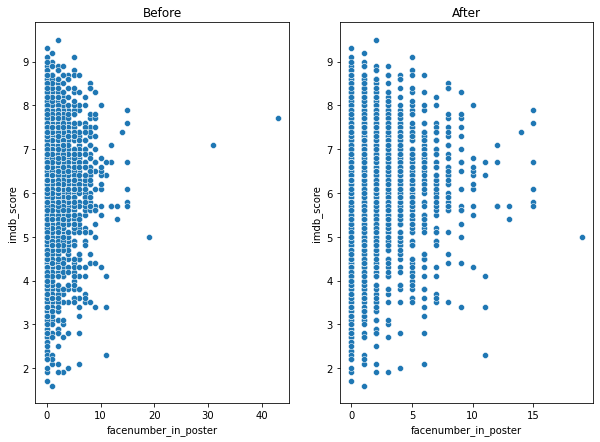

In [8]:
# facenumber_in_poster
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,7))
sns.scatterplot(x='facenumber_in_poster', y="imdb_score", data=df_d_m, ax = ax1)
sns.scatterplot(x='facenumber_in_poster', y="imdb_score", data=df_d_m[df_d_m['facenumber_in_poster']< 30], ax = ax2)
ax1.title.set_text('Before')
ax2.title.set_text('After')
plt.show()

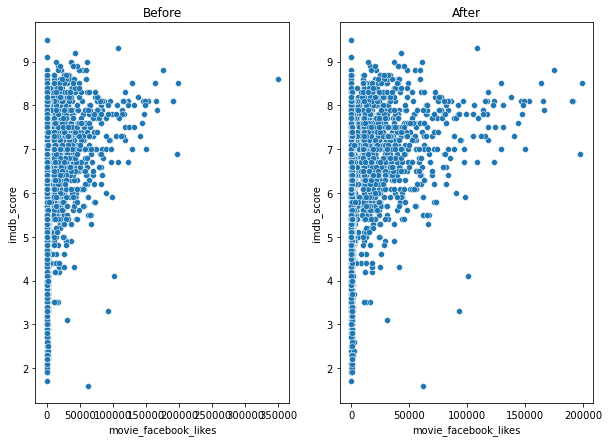

In [9]:
#moive_facebook_likes data=df[df['movie_facebook_likes']>1000000]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,7))
sns.scatterplot(x='movie_facebook_likes', y="imdb_score", data=df_d_m, ax = ax1)
sns.scatterplot(x='movie_facebook_likes', y="imdb_score", data=df_d_m[df_d_m['movie_facebook_likes']<300000], ax = ax2)
ax1.title.set_text('Before')
ax2.title.set_text('After')
plt.show()

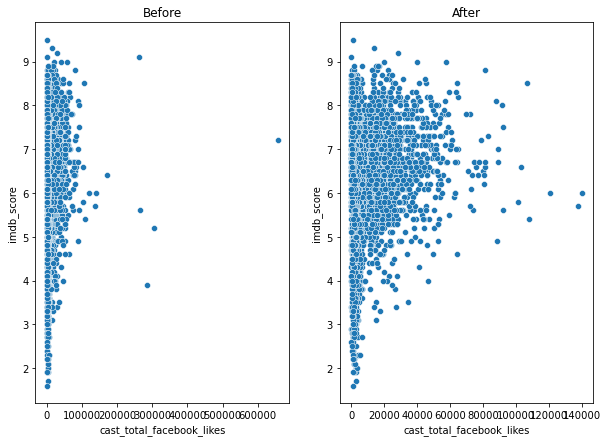

In [10]:
#cast_total_facebook_likes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,7))
sns.scatterplot(x='cast_total_facebook_likes', y="imdb_score", data=df_d_m, ax = ax1)
sns.scatterplot(x='cast_total_facebook_likes', y="imdb_score", data=df_d_m[df_d_m['cast_total_facebook_likes']<150000], ax = ax2)
ax1.title.set_text('Before')
ax2.title.set_text('After')
plt.show()

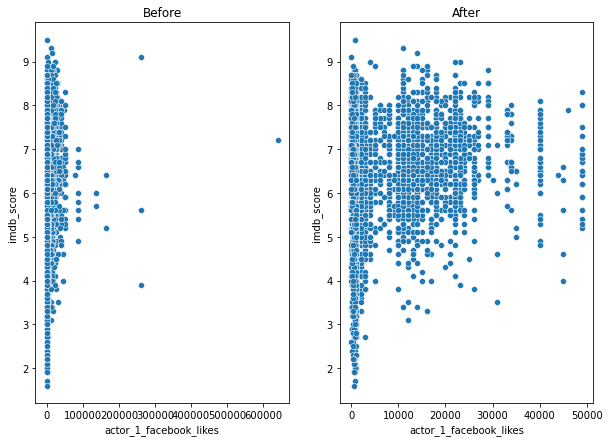

In [11]:
#actor_1_facebook_likes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,7))
sns.scatterplot(x='actor_1_facebook_likes', y="imdb_score", data=df_d_m, ax = ax1)
sns.scatterplot(x='actor_1_facebook_likes', y="imdb_score", data=df_d_m[df_d_m['actor_1_facebook_likes']<70000], ax = ax2)
ax1.title.set_text('Before')
ax2.title.set_text('After')
plt.show()

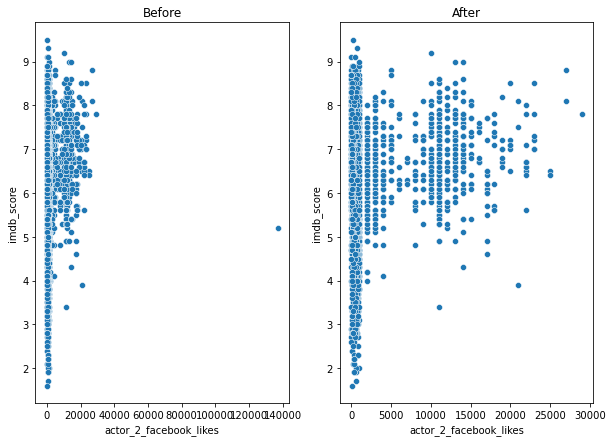

In [12]:
# actor_2_fackbook_like
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,7))
sns.scatterplot(x='actor_2_facebook_likes', y="imdb_score", data=df_d_m, ax = ax1)
sns.scatterplot(x='actor_2_facebook_likes', y="imdb_score", data=df_d_m[df_d_m['actor_2_facebook_likes']<40000], ax = ax2)
ax1.title.set_text('Before')
ax2.title.set_text('After')
plt.show()

In [13]:
# function to remove ooutliers from dataset
def remove_outliers(df):
    df = df[df['duration']<400]
    df = data=df[df['budget']< 3.5* 10**8]
    df = data=df[df['facenumber_in_poster']< 30]
    df = df[df['movie_facebook_likes']<300000]
    df = df[df['cast_total_facebook_likes']<150000]
    df = df[df['actor_1_facebook_likes']<70000]
    df = df[df['actor_2_facebook_likes']<40000]
    df = df.reset_index(drop = True)
    return df

In [14]:
df_d_m_o = remove_outliers(df_d_m)

### Featrue engineering
#### Basic rules
For categorical varialbes, the basic strategy is to generate dummy variables via one-hot encoding.
- For variables that unique values less then 10, create dummy variables directly.
- For variavles that unique values greate than 10 but less than 100, create dummy variables based on value frequency(low frequency values will be assigned to 'Other type')
- For variables including too many unique values, implement hashing encoding technique

For numeric variables, transform non-normal distribution variables into normal distribution via Box-Cox power transformation

#### Special rules
1. For movie_title and plot_keywords, create two new features: word_num, and avg_length.
2. remove movie_imdb_link directly

In [18]:
# function to split a string by seg
def split_keywords(string, seg = '|'):
    s = string.split(seg)
    return s

# funtion to calculate a splited string's avg length
def avg_keywords(string, seg = '|'):
    s = split_keywords(string, seg = seg)
    l = 0
    for word in s:
        l+=len(s)
    return l/len(s)

def frequency_calculator(df, col, threshold = 0.90):
    fre = df[col].value_counts()/len(df[col])
    n = len(fre[fre.cumsum(axis = 0) < threshold])
    return fre.index[0:n+1].tolist()

def recode_feature(string, values):
    if string in values:
        return string
    else:
        return 'Other'
    
def group_cate_variables(df, ex = ['movie_title', 'plot_keywords', 'genres']):
    df = df.drop(ex, axis = 1)
    cate_vars, num_vars = get_cvariables_type(df)
    low_uni_var = df[cate_vars].nunique()[df[cate_vars].nunique() <= 10].index.tolist()
    med_uni_var = df[cate_vars].nunique()[(df[cate_vars].nunique() <= 100) & (df[cate_vars].nunique() > 10)].index.tolist()
    high_uni_var = df[cate_vars].nunique()[df[cate_vars].nunique() >100].index.tolist()
    return low_uni_var, med_uni_var, high_uni_var
    
def genres2dummy(df):
    strings = df['genres'].values.tolist()
    gs = []
    for string in strings:
        gs += split_keywords(string)
    names = list(set(gs))
    for name in names:
        df[name] = df['genres'].apply(lambda x: 1 if name in x else 0)
    df = df.drop('genres', axis = 1)
    return df
 
def zero_check(x):
    if x == 0:
        return math.exp(-10)
    else:
        return x
    
    
def feature_transformation(df):
    X = df.drop('imdb_score', axis = 1)
    y = df['imdb_score'].values
    
    low_uni_var, med_uni_var, high_uni_var = group_cate_variables(X)
    one_hot_vars = low_uni_var + med_uni_var
    
    for var in med_uni_var:
        values = frequency_calculator(X, var)
        X[var] = X[var].apply(lambda x: recode_feature(x, values))
    
    # generate features for 'movie_title', 'plot_keywords'
    X['movie_title_word_nums'] = X['movie_title'].apply(lambda x: len(split_keywords(x, seg = ' ')))
    X['movie_title_avg_length'] = X['movie_title'].apply(lambda x: avg_keywords(x, seg = ' '))
    
    X['plot_keywords_word_nums'] = X['plot_keywords'].apply(lambda x: len(split_keywords(x)))
    X['plot_keywords_avg_length'] = X['plot_keywords'].apply(avg_keywords)
    
    X = X.drop(['movie_title', 'plot_keywords'], axis = 1)
    
    
    # Box-Cox power transformation for numeric variables excluding one-hot code variables
    cate_vars, num_vars = get_cvariables_type(df)
    
    num_vars.remove('title_year') # title_year is a ordinal variable
    for col in num_vars:
        X[col]  = X[col].apply(zero_check)
        xt, _ = boxcox(X[col].values)
        X[col] = xt
                  
    # encoding categorical variables            
    X = genres2dummy(X)
    X = pd.get_dummies(X, columns = one_hot_vars, drop_first = True)
    
    cehash = ce.HashingEncoder(cols =high_uni_var)
    X = cehash.fit_transform(X,y)
    return X, y


def feature_transformation2(df):
    X = df.drop('imdb_score', axis = 1)
    y = df['imdb_score'].values
    
    low_uni_var, med_uni_var, high_uni_var = group_cate_variables(X, ex = ['movie_title', 'plot_keywords'])
    hashing_vars = high_uni_var + med_uni_var

    
    # generate features for 'movie_title', 'plot_keywords'
    X['movie_title_word_nums'] = X['movie_title'].apply(lambda x: len(split_keywords(x, seg = ' ')))
    X['movie_title_avg_length'] = X['movie_title'].apply(lambda x: avg_keywords(x, seg = ' '))
    
    X['plot_keywords_word_nums'] = X['plot_keywords'].apply(lambda x: len(split_keywords(x)))
    X['plot_keywords_avg_length'] = X['plot_keywords'].apply(avg_keywords)
    
    X = X.drop(['movie_title', 'plot_keywords'], axis = 1)
    
                  
    # encoding categorical variables
    X = pd.get_dummies(X, columns = low_uni_var, drop_first = True)
    cehash = ce.HashingEncoder(cols =hashing_vars)
    X = cehash.fit_transform(X,y)
    return X, y

In [19]:
X, y = feature_transformation2(df_d_m_o)

In [21]:
X.to_csv('features.csv',index = False)
df_d_m_o['imdb_score'].to_csv("dependent_var.csv", index = False)